# MLP Experiments on muvr data

First we need to setup the environment and import all the necessary stuff.

In [1]:
%matplotlib inline

import shutil
import numpy as np
from os import remove
import cPickle as pkl
from os.path import expanduser, exists
import os
import sys
import logging

logging.basicConfig(level=10)
logger = logging.getLogger()

# Add the mlp python src director to the import search path
mlp_folder = "../mlp"
sys.path.append(os.path.abspath(mlp_folder))

# Now we are able to use all the packages defined in mlp_folder
# import training.acceleration_dataset

This time we are not going to generate the data but rather use real world annotated training examples.

In [2]:
from training.acceleration_dataset import AccelerationDataset

dataset = AccelerationDataset('datasets/combined/18-09-15-triceps-biceps-lateral/')

print "Number of training examples:", dataset.num_train_examples
print "Number of test examples:", dataset.num_test_examples
print "Number of features:", dataset.num_features
print "Number of labels:", dataset.num_labels

Dropped an example because it was to short. Length: 91
Augmented `train` with 6829 examples, 67 originally
Augmented `test` with 1969 examples, 17 originally
Number of training examples: 6896
Number of test examples: 1986
Number of features: 1200
Number of labels: 3


At first we want to inspect the class distribution of the training and test examples.

In [3]:
from ipy_table import *
from operator import itemgetter

def calculate_dist(labels):
    dist = np.zeros((dataset.num_labels, 1))
    for i in range(0, len(labels)):
        dist[labels[i], 0] += 1
    return dist

train_dist = calculate_dist(dataset.y_train)
test_dist = calculate_dist(dataset.y_test)

train_ratio = train_dist / dataset.num_train_examples
test_ratio = test_dist / dataset.num_test_examples

# Fiddle around to get it into table shape
table = np.hstack((np.zeros((dataset.num_labels,1), dtype=int), train_dist, train_ratio, test_dist, test_ratio))
table = np.vstack((np.zeros((1, 5), dtype=int), table)).tolist()

human_labels = map(dataset.human_label_for, range(0,dataset.num_labels))

for i,s in enumerate(human_labels):
    table[i + 1][0] = s
    
table.sort(lambda x,y: cmp(x[1], y[1]))

table[0][0] = ""
table[0][1] = "Train"
table[0][2] = "Train %"
table[0][3] = "Test"
table[0][4] = "Test %"

make_table(table)
set_global_style(float_format='%0.0f', align="center")
set_column_style(2, float_format='%0.2f%%')
set_column_style(4, float_format='%0.2f%%')
set_column_style(0, align="left")

/Users/mostafa/src/muvr/muvr-analytics/venv/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


,Train,Train %,Test,Test %
arms/triceps-extension,1634,0.24%,361,0.18%
shoulders/lateral-raise,2338,0.34%,614,0.31%
arms/biceps-curl,2924,0.42%,1011,0.51%


Let's have a look at the generated data. We will plot some of the examples of the different classes.

Ids of plotted examples: [2409 5240 3400]


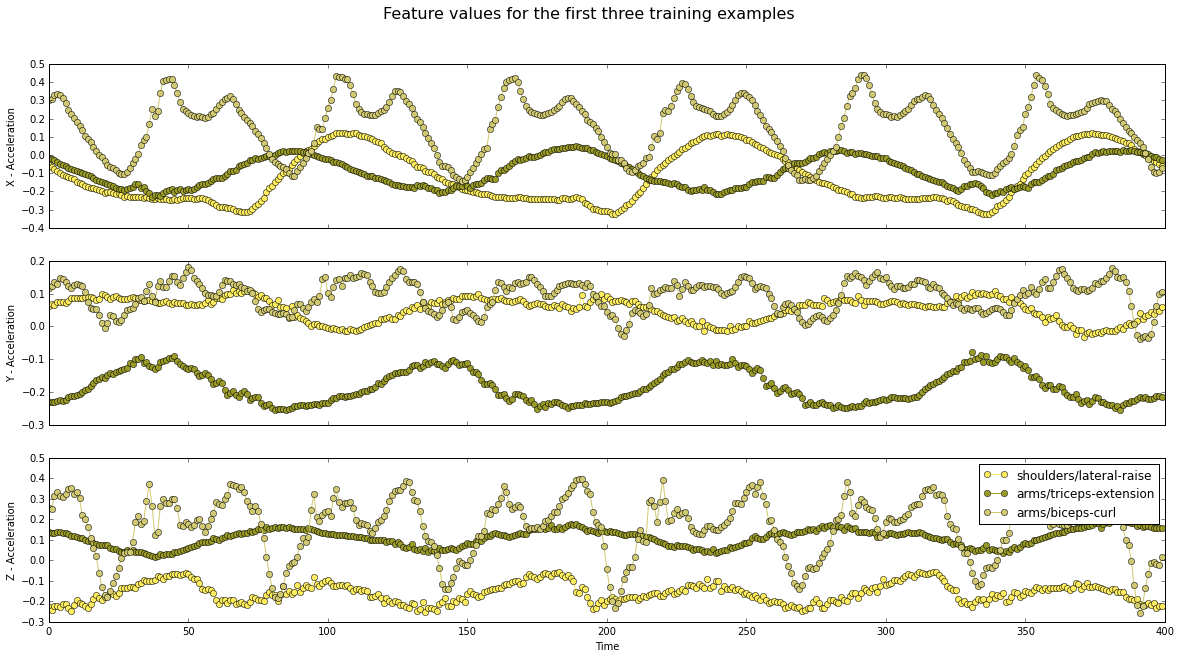

In [4]:
from matplotlib import pyplot, cm
from pylab import *

# Choose some random examples to plot from the training data
number_of_examples_to_plot = 3
plot_ids = np.random.random_integers(0, dataset.num_train_examples - 1, number_of_examples_to_plot)

print "Ids of plotted examples:",plot_ids

# Retrieve a human readable label given the idx of an example
def label_of_example(i):
    return dataset.human_label_for(dataset.y_train[i])

figure(figsize=(20,10))
ax1 = subplot(311)
setp(ax1.get_xticklabels(), visible=False)
ax1.set_ylabel('X - Acceleration')

ax2 = subplot(312, sharex=ax1)
setp(ax2.get_xticklabels(), visible=False)
ax2.set_ylabel('Y - Acceleration')

ax3 = subplot(313, sharex=ax1)
ax3.set_ylabel('Z - Acceleration')

for i in plot_ids:
    c = np.random.random((3,))

    ax1.plot(range(0, dataset.num_features / 3), dataset.X_train[i,0:400], '-o', c=c)
    ax2.plot(range(0, dataset.num_features / 3), dataset.X_train[i,400:800], '-o', c=c)
    ax3.plot(range(0, dataset.num_features / 3), dataset.X_train[i,800:1200], '-o', c=c)
    
legend(map(label_of_example, plot_ids))
suptitle('Feature values for the first three training examples', fontsize=16)
xlabel('Time')
show()

Now we are going to create a neon model. We will start with a realy simple one layer preceptron having 500 hidden units.

In [ ]:
from training.mlp_model import MLPMeasurementModel
from neon.layers import Affine, Dropout, GeneralizedCost
from neon.transforms import Rectlin, Logistic
from neon.initializers import Uniform, Constant
from neon.models import Model

# Lets define our neural network
init_norm = Uniform(low=-0.1,high=0.1)
bias_init = Constant(val = 1.0)    

layers = []
layers.append(Affine(
        nout=250, 
        init=init_norm, 
        bias=bias_init,
        activation=Rectlin()))

layers.append(Dropout(
        name="do_2", 
        keep = 0.9))

layers.append(Affine(
        nout=100, 
        init=init_norm, 
        bias=bias_init,
        activation=Rectlin()))

layers.append(Dropout(
        name="do_3", 
        keep = 0.9))

layers.append(Affine(
        nout = dataset.num_labels, 
        init=init_norm, 
        bias=bias_init,
        activation=Logistic()))

mlpmodel = MLPMeasurementModel('models')

model = mlpmodel.train(dataset)

To check weather the network is learning something we will plot the weight matrices of the different training epochs.

In [ ]:
import numpy as np
import math
from matplotlib import pyplot, cm
from pylab import *
from IPython.html import widgets
from IPython.html.widgets import interact

layer_names = map(lambda l: l[1].name+"_"+str(l[0]), filter(lambda l: l[1].has_params, enumerate(model.layers)))

def closestSqrt(i):
    N = int(math.sqrt(i))
    while True:
        M = int(i / N)
        if N * M == i:
            return N, M
        N -= 1
        
def plot_filters(**kwargs):
    n = kwargs['n']
    layer_name = kwargs['layer']
    dest_path = os.path.join('models', 'workout-mlp-ep_' + str(n))
    params = pkl.load(open(dest_path, 'r'))
    
    wts = params['layer_params_states'][layer_names.index(layer_name)]['params']

    nrows, ncols = closestSqrt(wts.shape[0])
    fr, fc = closestSqrt(wts.shape[1])
    
    fi = 0

    W = np.zeros((fr*nrows, fc*ncols))
    for row, col in [(row, col) for row in range(nrows) for col in range(ncols)]:
        W[fr*row:fr*(row+1):,fc*col:fc*(col+1)] = wts[fi].reshape(fr,fc)
        fi = fi + 1

    matshow(W, cmap=cm.gray)
    title('Visualizing weights of '+layer_name+' in epoch ' + str(n) )
    show()

_i = interact(plot_filters,
              layer=widgets.widget_selection.ToggleButtons(options = layer_names),
              n=widgets.IntSlider(description='epochs',
                                        min=0, max=mlpmodel.max_epochs-1, value=0, step=1))


Let's visualize the error to see if the network has trained properly or if we are overfitting.

In [ ]:
import h5py
from neon.transforms import Misclassification

logged = h5py.File(os.path.join('models', 'workout-mlp.h5'), "r")
epochs = logged['config'].attrs['total_epochs']
minibatches = logged['config'].attrs['total_minibatches']

print('Test error = %.1f%%'
      % (model.eval(dataset.test(), metric=Misclassification())*100))

print('Train error = %.1f%%'
      % (model.eval(dataset.train(), metric=Misclassification())*100))

print "Minibatches per epoch: %0.2f" % (minibatches * 1.0/epochs)

pyplot.plot(range(0, minibatches), logged['cost/train'], linewidth=3, label='train')
pyplot.plot(range(minibatches / epochs, minibatches, minibatches / epochs), logged['cost/validation'], linewidth=3, label='test')
pyplot.grid()
pyplot.legend()
pyplot.xlabel("minibatch")
pyplot.ylabel("cost")
pyplot.show()

Let's also have a look at the confusion matrix for the test dataset.

In [ ]:
from sklearn.metrics import confusion_matrix
from ipy_table import *

def predict(model, dataset):
    running_error = 0.0
    nprocessed = 0
    dataset.reset()
    predictions = np.empty((3, 0), dtype="float32")
    nprocessed = 0
    for x, t in dataset:
        pred = model.fprop(x, inference=True).asnumpyarray()
        bsz = min(dataset.ndata - nprocessed, model.be.bsz)
        nprocessed += bsz
        predictions = np.hstack((predictions, pred[:,:bsz]))
    return predictions

# confusion_matrix(y_true, y_pred)
predicted = predict(model, dataset.test())

y_true = dataset.y_test
y_pred = np.argmax(predicted, axis = 0) 

confusion_mat = confusion_matrix(y_true, y_pred, range(0,dataset.num_labels))

# Fiddle around with cm to get it into table shape
confusion_mat = vstack((np.zeros((1,dataset.num_labels), dtype=int), confusion_mat))
confusion_mat = hstack((np.zeros((dataset.num_labels + 1, 1), dtype=int), confusion_mat))

table = confusion_mat.tolist()

human_labels = map(dataset.human_label_for, range(0,dataset.num_labels))

for i,s in enumerate(human_labels):
    table[0][i+1] = s
    table[i+1][0] = s

table[0][0] = "actual \ predicted"

mt = make_table(table)
set_row_style(0, color='lightGray', rotate = "315deg")
set_column_style(0, color='lightGray')
set_global_style(align='center')

for i in range(1, dataset.num_labels + 1):
    for j in range(1, dataset.num_labels + 1):
        if i == j:
            set_cell_style(i,j, color='lightGreen', width = 80)
        elif table[i][j] > 20:
            set_cell_style(i,j, color='Pink')
        elif table[i][j] > 0:
            set_cell_style(i,j, color='lightYellow')
mt